In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

### Load data

In [2]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

### Load original data (train.pickle etc.) and pre-calculated BERT CLS states ("train_cls.npy" etc.)

In [3]:
train = load_dataset("../data/biasbios/train.pickle")
dev = load_dataset("../data/biasbios/dev.pickle")
test = load_dataset("../data/biasbios/test.pickle")
counter = count_profs_and_gender(train+dev+test)
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")

path = "../data/bert_encode_biasbios/"
x_train = np.load(path + "train_cls.npy")
x_dev = np.load(path + "dev_cls.npy")
x_test = np.load(path + "test_cls.npy")

assert len(train) == len(x_train)
assert len(dev) == len(x_dev)
assert len(test) == len(x_test)

f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.44541700643683746
{'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}


In [4]:
y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])

In [5]:
train[1]

{'g': 'm',
 'p': 'professor',
 'text': 'Dr. Bilal Gonen is an Assistant Professor in the Computer Science Department at the University of West Florida. He received his Ph.D. from University of Nevada, Reno. He received his M.S. from the University of Georgia. He received a B.E. in Computer Engineering in Turkey. His teaching and research interests include Network Science, Social Network Analysis, Semantic Web, Computer Networks, Machine learning, Data Mining, Bioinformatics, programming in Java, C, C++, C#, Python.',
 'start': 111,
 'hard_text': 'He received his Ph.D. from University of Nevada, Reno. He received his M.S. from the University of Georgia. He received a B.E. in Computer Engineering in Turkey. His teaching and research interests include Network Science, Social Network Analysis, Semantic Web, Computer Networks, Machine learning, Data Mining, Bioinformatics, programming in Java, C, C++, C#, Python.',
 'text_without_gender': '_ received _ Ph.D. from University of Nevada, Reno.

### Train a profession classifier

In [ ]:
random.seed(0)
np.random.seed(0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)

#params = {'}
#clf = SGDClassifier(loss= 'hinge', max_iter = 4000, fit_intercept= True, class_weight= None, n_jobs= 100)
        
        
start = time.time()
idx = np.random.rand(x_train.shape[0]) < 1.0
clf.fit(x_train[idx], y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(x_test, y_test))
clf_original = copy.deepcopy(clf)

## Run vanilla svd

In [6]:
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_train_gender = np.array([g2i[d["g"]] for d in train])
y_test_gender = np.array([g2i[d["g"]] for d in test])
# idx = np.random.rand(x_train.shape[0]) < 1.
y_train_gender_2d = np.asarray([y_train_gender, - y_train_gender + 1]).T

In [7]:
y_dev_gender.shape, y_train_gender.shape, y_test_gender.shape

((11550,), (74882,), (28842,))

In [8]:
A = np.dot(x_train.T, y_train_gender_2d) / x_train.shape[0]
t = time.time()
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")
elapsed = time.time() - t
print(f"vSVD took {elapsed} seconds")

u has shape (768, 768), s has shape (2,), vh has shape (2, 2)
vSVD took 0.4082608222961426 seconds


In [ ]:
# # removal = 1
# # u_r = u[:, removal:]
# # proj = u_r @ u_r.T
# # P = proj

# # debiased_x_train_1 = P.dot(x_train.T).T
# # debiased_x_dev_1 = P.dot(x_dev.T).T
# # debiased_x_test_1 = P.dot(x_test.T).T

# removal = 2
# u_r = u[:, removal:]
# proj = u_r @ u_r.T
# P = proj

# debiased_x_train_2 = P.dot(x_train.T).T
# debiased_x_dev_2 = P.dot(x_dev.T).T
# debiased_x_test_2 = P.dot(x_test.T).T

In [14]:
# np.savez("BERT.npz", u = u, s = s, vh = vh, 
#          x_train = x_train, x_test = x_test, 
#          debiased_x_train_1 = debiased_x_train_1, debiased_x_test_1 = debiased_x_test_1, 
#          debiased_x_train_2 = debiased_x_train_2, debiased_x_test_2 = debiased_x_test_2, 
#          y_train_gender = y_train_gender, y_train = y_train, 
#          y_test_gender = y_test_gender, y_test = y_test)

In [12]:
# removal = 40
# u_r = u[:, removal:]
# proj = u_r @ u_r.T
# P = proj

# debiased_x_train = P.dot(x_train.T).T
# debiased_x_dev = P.dot(x_dev.T).T
# debiased_x_test = P.dot(x_test.T).T

In [80]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR2(y_pred, y_true, p2i, i2p, y_gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)    


    label_set = set(y_true)
    # count false positive per gender & class
    
    for y_hat, y, g in zip(y_pred, y_true, y_gender):
        
        if y != y_hat:
            
            fp[y_hat][g] += 1 # count false positives for y_hat
    
    # count total falses per gender (conditioned on class)
    
    total_prof_g = defaultdict(Counter)
    
    # collect POSITIVES for each profession and gender
    
    for y,g in zip(y_true, y_gender):
        total_prof_g[y][g] += 1
    
    total_m = sum([total_prof_g[y]["m"] for y in label_set])
    total_f = sum([total_prof_g[y]["f"] for y in label_set])
    
    # calculate NEGATIVES for each profession and gender
    
    total_false_prof_g = defaultdict(Counter)    
    for y in label_set:
        total_false_prof_g[y]["m"] = total_m - total_prof_g[y]["m"]
        total_false_prof_g[y]["f"] = total_f - total_prof_g[y]["f"]
    
    fprs = defaultdict(dict)
    fprs_diff = dict()
    
    for profession, false_pred_dict in fp.items():

        false_male, false_female = false_pred_dict["m"],  false_pred_dict["f"]
        prof_total_false_for_male = total_false_prof_g[profession]["m"]
        prof_total_false_for_female = total_false_prof_g[profession]["f"]
        
        ftr_m = false_male/prof_total_false_for_male
        ftr_f = false_female/prof_total_false_for_female
        fprs[i2p[profession]]["m"] = ftr_m
        fprs[i2p[profession]]["f"] = ftr_f
        fprs_diff[i2p[profession]] = ftr_m - ftr_f
    
    return fprs, fprs_diff
        

    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

### Finetune & predict profession again

In [ ]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


# print(clf.fit(debiased_x_train, y_train))
# #print(clf.fit((x_train.T).T + mean_gender_vec, y_train))

In [ ]:
0.print(clf.score(debiased_x_test, y_test))
# #print(clf.score(x_test.dot(P), y_test))
# #print(clf_original.score(x_test, y_test))

### Calcualte TPR-gap vs. %woman in profession; TPR-Gap-RMS

In [9]:
# removal = 1
removal = 2
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


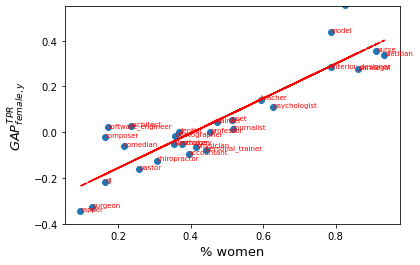

Correlation: 0.7250648795926602; p-value: 1.2743504290072345e-05


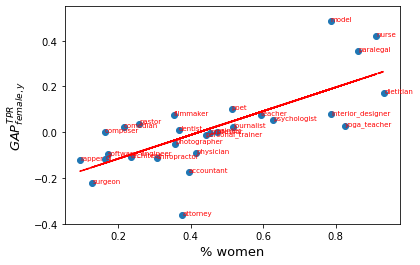

rms-diff before: 0.2138363635561522; rms-diff after: 0.177962429021077


In [11]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict(debiased_x_test)
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
""" 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))


In [17]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


print(clf.fit(debiased_x_train, y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 36 seconds
LogisticRegression(max_iter=3, multi_class='multinomial', n_jobs=64,
                   random_state=1, solver='sag', verbose=10, warm_start=True)


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   35.3s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   35.3s finished


In [18]:
print(clf.score(debiased_x_test, y_test))

0.7862492198876638


In [ ]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


# clf.fit(x_train, y_train)
# print(clf.score(debiased_x_test, y_test))

In [ ]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)
# clf.fit(x_train, y_train)

# print(f"Biased Train accuracy {clf.score(x_train, y_train)}")
# print(f"Biased Train accuracy {clf.score(x_test, y_test)}")
# print(f"Train accuracy {clf.score(debiased_x_train, y_train)}")
# print(f"Test accuracy {clf.score(debiased_x_test, y_test)}")

In [10]:
removal = 2
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


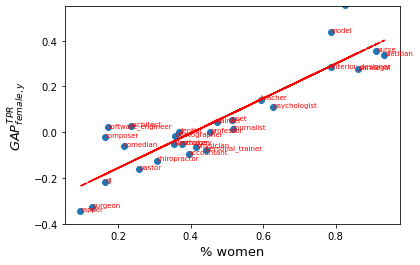

Correlation: 0.4004490396545621; p-value: 0.034716753722612126


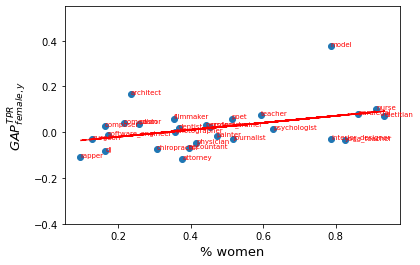

rms-diff before: 0.2138363635561522; rms-diff after: 0.09613577308212172


In [13]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict(debiased_x_test)
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
""" 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))


In [14]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


print(clf.fit(debiased_x_train, y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 35 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   35.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   35.8s finished


LogisticRegression(max_iter=3, multi_class='multinomial', n_jobs=64,
                   random_state=1, solver='sag', verbose=10, warm_start=True)


In [15]:
print(clf.score(debiased_x_test, y_test))

0.7862838915470495


In [11]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


# clf.fit(x_train, y_train)
# print(clf.score(debiased_x_test, y_test))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 19 seconds
0.543859649122807


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   18.5s finished


In [17]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)
# clf.fit(x_train, y_train)

# print(f"Biased Train accuracy {clf.score(x_train, y_train)}")
# print(f"Biased Train accuracy {clf.score(x_test, y_test)}")
# print(f"Train accuracy {clf.score(debiased_x_train, y_train)}")
# print(f"Test accuracy {clf.score(debiased_x_test, y_test)}")

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 19 seconds
Biased Train accuracy 0.7668064421356268
Biased Train accuracy 0.7509187989737189


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   18.6s finished


Train accuracy 0.5521620683208248
Test accuracy 0.543859649122807


In [18]:
removal = 20
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

Correlation: 0.8937249691226158; p-value: 1.5274617312543798e-10


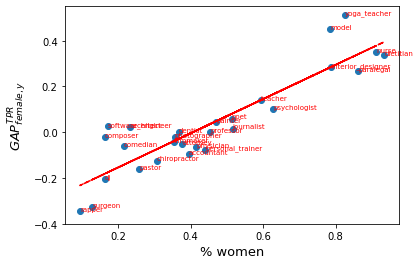

Correlation: 0.4043719648778907; p-value: 0.032819064236830627


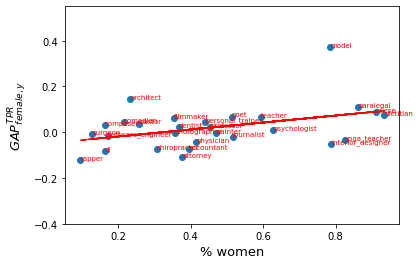

rms-diff before: 0.20980340942767006; rms-diff after: 0.0956107947911571


In [13]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict(debiased_x_test)
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
""" 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))


In [14]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


# print(clf.fit(debiased_x_train, y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 18 seconds
LogisticRegression(max_iter=3, multi_class='multinomial', n_jobs=64,
                   random_state=1, solver='sag', verbose=10, warm_start=True)


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   18.5s finished


In [15]:
# print(clf.score(debiased_x_test, y_test))

0.7870466680535331


In [13]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)


# clf.fit(x_train, y_train)
# print(clf.score(debiased_x_test, y_test))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 18 seconds
0.5447957839262187


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   18.6s finished


In [19]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)
# clf.fit(x_train, y_train)

# print(f"Biased Train accuracy {clf.score(x_train, y_train)}")
# print(f"Biased Train accuracy {clf.score(x_test, y_test)}")
# print(f"Train accuracy {clf.score(debiased_x_train, y_train)}")
# print(f"Test accuracy {clf.score(debiased_x_test, y_test)}")

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 18 seconds
Biased Train accuracy 0.7668064421356268


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   18.6s finished


Biased Train accuracy 0.7509187989737189
Train accuracy 0.5535776288026495
Test accuracy 0.5447957839262187


### t-SNE by gender

In [9]:
# def load_word_vectors(fname):
    
#     model = KeyedVectors.load_word2vec_format(fname, binary=False)
#     vecs = model.vectors
#     words = list(model.vocab.keys())
#     return model, vecs, words

In [12]:
# # 150k top vectors (with gender-typical words) - used for training

# model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/glove.42B.300d.txt")

In [11]:
removal = 2
u_r = u[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

In [12]:
i2p

{0: 'accountant',
 1: 'architect',
 2: 'attorney',
 3: 'chiropractor',
 4: 'comedian',
 5: 'composer',
 6: 'dentist',
 7: 'dietitian',
 8: 'dj',
 9: 'filmmaker',
 10: 'interior_designer',
 11: 'journalist',
 12: 'model',
 13: 'nurse',
 14: 'painter',
 15: 'paralegal',
 16: 'pastor',
 17: 'personal_trainer',
 18: 'photographer',
 19: 'physician',
 20: 'poet',
 21: 'professor',
 22: 'psychologist',
 23: 'rapper',
 24: 'software_engineer',
 25: 'surgeon',
 26: 'teacher',
 27: 'yoga_teacher'}

In [13]:
OM = []
OF = []
for i in range(28):
    x_train_selected = x_train[y_train == i]
    y_train_gender_selected = y_train_gender[y_train == i]

    x_train_male = x_train_selected[y_train_gender_selected == 1]
    x_train_female = x_train_selected[y_train_gender_selected == 0]
    OM.append(x_train_male)
    OF.append(x_train_female)

PM = []
PF = []
for i in range(28):
    x_train_selected = debiased_x_train[y_train == i]
    y_train_gender_selected = y_train_gender[y_train == i]

    x_train_male = x_train_selected[y_train_gender_selected == 1]
    x_train_female = x_train_selected[y_train_gender_selected == 0]
    PM.append(x_train_male)
    PF.append(x_train_female)

In [25]:
io.savemat(f"../../BERT_profession_gender_biography.mat", \
           mdict={'list_of_professions': list(i2p.values()), 'OM': OM, 'OF': OF, 'PM': PM, 'PF': PF})

In [24]:
cd CCA_debiase/notebooks

/mnt/lustre/indy2lfs/work/sc066/sc066/shunshao/code/CCA_debiase/notebooks


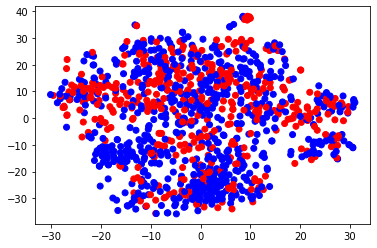

In [34]:
debiased_x_train_selected = debiased_x_train[y_train == 0]
y_train_selected = y_train[y_train == 0]
y_train_gender_selected = y_train_gender[y_train == 0]
tsne = TSNE(n_components=2, random_state=0)
debiased_x_train_selected_2d = tsne.fit_transform(debiased_x_train_selected)
plt.scatter(debiased_x_train_selected_2d[: , 0], debiased_x_train_selected_2d[: , 1], \
            c = y_train_gender_selected, cmap = 'bwr')


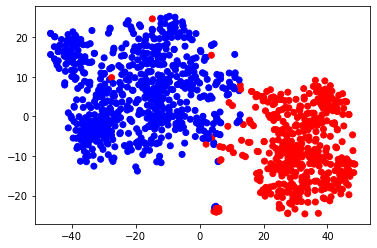

In [33]:
x_train_selected = x_train[y_train == 0]
y_train_selected = y_train[y_train == 0]
y_train_gender_selected = y_train_gender[y_train == 0]
tsne = TSNE(n_components=2, random_state=0)
x_train_selected_2d = tsne.fit_transform(x_train_selected)
plt.scatter(x_train_selected_2d[: , 0], x_train_selected_2d[: , 1], \
            c = y_train_gender_selected, cmap = 'bwr')


In [40]:
index_selected = y_train_gender_selected == 0
target = x_train_selected_2d[index_selected]
male_centroids = [np.mean(target[:, 0]), np.mean(target[:, 1])]
index_selected = y_train_gender_selected == 1
target = x_train_selected_2d[index_selected]
female_centriods = np.mean(target[:, 0]), np.mean(target[:, 1])

spreadability_male = 
spreadability_female = 

(30.628012, -7.849736)

In [25]:
debiased_x_train.shape

(74882, 768)

In [ ]:
np.mean*debiased_x_train

In [ ]:
def separability_metric_tsne(i, debiased_x_train, y_train, y_train_gender):

    debiased_x_train_selected = debiased_x_train[y_train == i]
    y_train_selected = y_train[y_train == i]
    y_train_gender_selected = y_train_gender[y_train == i]

    index_selected = y_train_gender_selected == 0
    target = debiased_x_train_selected[index_selected]
    male_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])]).reshape(1,2)
    result = (target - male_centroids)**2
    spreadability_male = np.mean(np.sum(result, axis=1))


    index_selected = y_train_gender_selected == 1
    target = x_train_selected_2d[index_selected]
    female_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])])
    result = (target - female_centroids)**2
    spreadability_female = np.mean(np.sum(result, axis=1))
    
    return spreadability_male, spreadability_female

In [23]:
def separability_metric_tsne(i, x_train, y_train, y_train_gender):
    
    x_train_selected = x_train[y_train == i]
    y_train_selected = y_train[y_train == i]
    y_train_gender_selected = y_train_gender[y_train == i]
    tsne = TSNE(n_components=2, random_state=0)
    x_train_selected_2d = tsne.fit_transform(x_train_selected)

    index_selected = y_train_gender_selected == 0
    target = x_train_selected_2d[index_selected]
    male_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])]).reshape(1,2)
    result = (target - male_centroids)**2
    spreadability_male = np.mean(np.sum(result, axis=1))


    index_selected = y_train_gender_selected == 1
    target = x_train_selected_2d[index_selected]
    female_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])])
    result = (target - female_centroids)**2
    spreadability_female = np.mean(np.sum(result, axis=1))
    
    return spreadability_male, spreadability_female

In [21]:
debiased_x_train.shape

AttributeError: 'str' object has no attribute 'shape'

In [24]:
for i in range(28):
    spreadability_male, spreadability_female = separability_metric(i, x_train, y_train, y_train_gender, debiased_x_train, real_vector=True)
    print(f"Profession: {i2p[i]},Biased separability, i = {i}, male {spreadability_male}, female {spreadability_female}\n")

for i in range(28):
    spreadability_male, spreadability_female = separability_metric(i, debiased_x_train, y_train, y_train_gender, debiased_x_train, real_vector=True)
    print(f"Profession: {i2p[i]},Debiased separability, i = {i}, male {spreadability_male}, female {spreadability_female}\n\n\n")

ValueError: operands could not be broadcast together with shapes (645,768) (1,2) 

In [17]:
for i in range(28):
    spreadability_male, spreadability_female = cool(i, x_train, y_train, y_train_gender)
    print(f"Profession: {i2p[i]},Biased separability, i = {i}, male {spreadability_male}, female {spreadability_female}\n")

    spreadability_male, spreadability_female = cool(i, debiased_x_train, y_train, y_train_gender)
    print(f"Profession: {i2p[i]},Debiased separability, i = {i}, male {spreadability_male}, female {spreadability_female}\n\n\n")

Profession: accountant,Biased separability, i = 0, male 305.4618225097656, female 195.8341064453125

Profession: accountant,Debiased separability, i = 0, male 514.5943603515625, female 458.08160400390625



Profession: architect,Biased separability, i = 1, male 666.6531982421875, female 272.93670654296875

Profession: architect,Debiased separability, i = 1, male 820.9407348632812, female 750.1602172851562



Profession: attorney,Biased separability, i = 2, male 1158.730712890625, female 720.6351928710938

Profession: attorney,Debiased separability, i = 2, male 1767.088623046875, female 1669.258544921875



Profession: chiropractor,Biased separability, i = 3, male 121.14393615722656, female 89.65074920654297

Profession: chiropractor,Debiased separability, i = 3, male 170.6328887939453, female 174.51736450195312



Profession: comedian,Biased separability, i = 4, male 149.94065856933594, female 56.04262161254883

Profession: comedian,Debiased separability, i = 4, male 181.6295928955078,

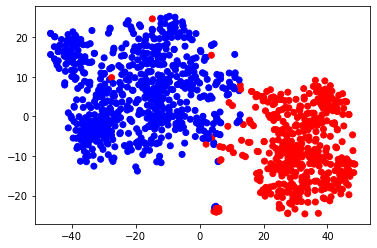

In [64]:
i = 0


x_train_selected = x_train[y_train == i]
y_train_selected = y_train[y_train == i]
y_train_gender_selected = y_train_gender[y_train == i]
tsne = TSNE(n_components=2, random_state=0)
x_train_selected_2d = tsne.fit_transform(x_train_selected)
plt.scatter(x_train_selected_2d[: , 0], x_train_selected_2d[: , 1], \
            c = y_train_gender_selected, cmap = 'bwr')

index_selected = y_train_gender_selected == 0
target = x_train_selected_2d[index_selected]
male_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])]).reshape(1,2)
result = (target - male_centroids)**2
spreadability_male = np.mean(np.sum(result, axis=1))


index_selected = y_train_gender_selected == 1
target = x_train_selected_2d[index_selected]
female_centroids = np.array([np.mean(target[:, 0]), np.mean(target[:, 1])])
result = (target - female_centroids)**2
spreadability_female = np.mean(np.sum(result, axis=1))

In [65]:
spreadability_male, spreadability_female

(305.46182, 195.8341)

In [54]:
result.shape

(645, 2)

In [55]:
(target - male_centroids)[:5]

array([[ -5.4733353,  -2.594727 ],
       [ -2.2905006,   8.654257 ],
       [  5.542836 ,   0.7656498],
       [  1.3953056,   2.1161103],
       [-21.757103 ,   9.834238 ]], dtype=float32)

In [56]:
result[:5]

array([[ 29.9574   ,   6.7326083],
       [  5.246393 ,  74.896164 ],
       [ 30.723034 ,   0.5862196],
       [  1.9468778,   4.477923 ],
       [473.37152  ,  96.712234 ]], dtype=float32)

In [61]:
result

305.46182

In [51]:
male_centroids.shape

(1, 2)

In [ ]:
    tsne = TSNE(n_components=2, random_state=0)
    vecs_2d = tsne.fit_transform(vecs)
    plt.figure(figsize=(25, 25))

    plt.scatter(vecs_2d[: , 0], vecs_2d[: , 1], c = labels, cmap = 'bwr')

In [29]:
professions_list = ['accountant','architect','attorney', 'chiropractor', 'comedian', 'composer', \
                    'dentist', 'dietitian', 'dj', 'filmmaker', 'interiordesign', 'journalist', \
                    'model', 'nurse', 'painter', 'paralegal', 'pastor','personaltrainer', \
                    'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper', \
                    'softwareengineer', 'surgeon', 'teacher', 'yoga']

professions_vecs = model[professions_list]
gender_direction = model["he"]-model["she"] 

projection_on_gender = np.dot(professions_vecs, gender_direction).reshape(28, 1) \
/ np.dot(np.linalg.norm(professions_vecs, axis = 1) , np.linalg.norm(gender_direction)).reshape(28, 1)

projection_order_from_min = projection_on_gender.reshape(1,28).argsort().reshape(28 , )

professions_list_by_gender = [professions_list[i] for i in projection_order_from_min]

professions_list_by_gender

['nurse',
 'dietitian',
 'yoga',
 'paralegal',
 'teacher',
 'softwareengineer',
 'interiordesign',
 'photographer',
 'model',
 'psychologist',
 'dentist',
 'chiropractor',
 'personaltrainer',
 'physician',
 'filmmaker',
 'journalist',
 'professor',
 'accountant',
 'attorney',
 'surgeon',
 'painter',
 'rapper',
 'poet',
 'comedian',
 'dj',
 'composer',
 'architect',
 'pastor']

In [75]:
projection_on_gender[projection_order_from_min]

array([[-0.2350638 ],
       [-0.19686082],
       [-0.13685137],
       [-0.0956063 ],
       [-0.08937778],
       [-0.08345857],
       [-0.07980894],
       [-0.05814403],
       [-0.04284415],
       [-0.03849148],
       [-0.02502192],
       [ 0.01658819],
       [ 0.01992983],
       [ 0.02741983],
       [ 0.03451487],
       [ 0.03621808],
       [ 0.03778296],
       [ 0.03816445],
       [ 0.05220212],
       [ 0.05633715],
       [ 0.05880935],
       [ 0.06156192],
       [ 0.06260957],
       [ 0.06553173],
       [ 0.08821873],
       [ 0.10756435],
       [ 0.15593946],
       [ 0.17030428]], dtype=float32)

In [71]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  plt.figure(figsize=(25, 25))

  plt.scatter(vecs_2d[: , 0], vecs_2d[: , 1], c = labels, cmap = 'bwr')
  plt.title(title, fontsize = 40)
  plt.show()
  return



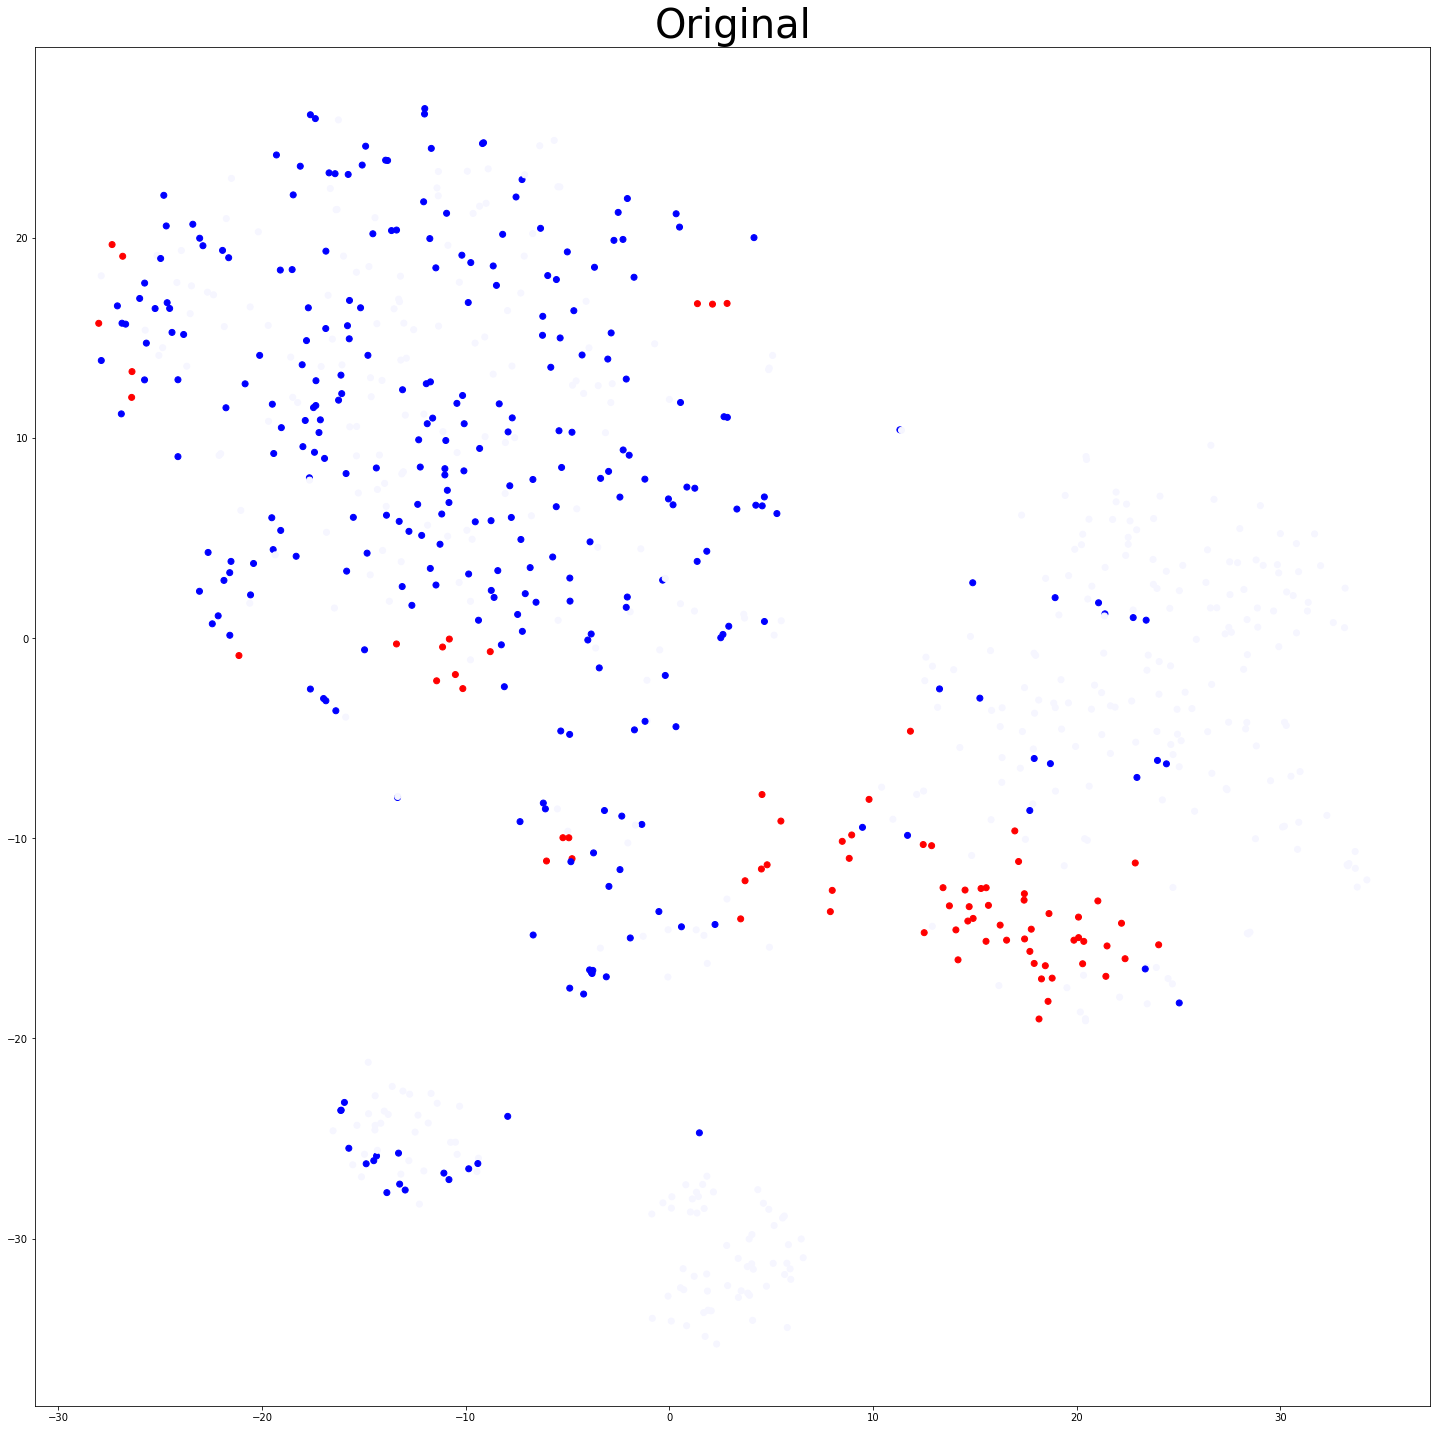

In [76]:
color_order = np.zeros(len(x_dev), )

for i in range(28):
    indices = np.where(y_dev == projection_order_from_min[i])
    color_order[indices] = i


a = color_order == 0
c = color_order == 13
b = color_order == 27
d = (a + b + c)

tsne_by_gender(x_dev[d], color_order[d], "Original")

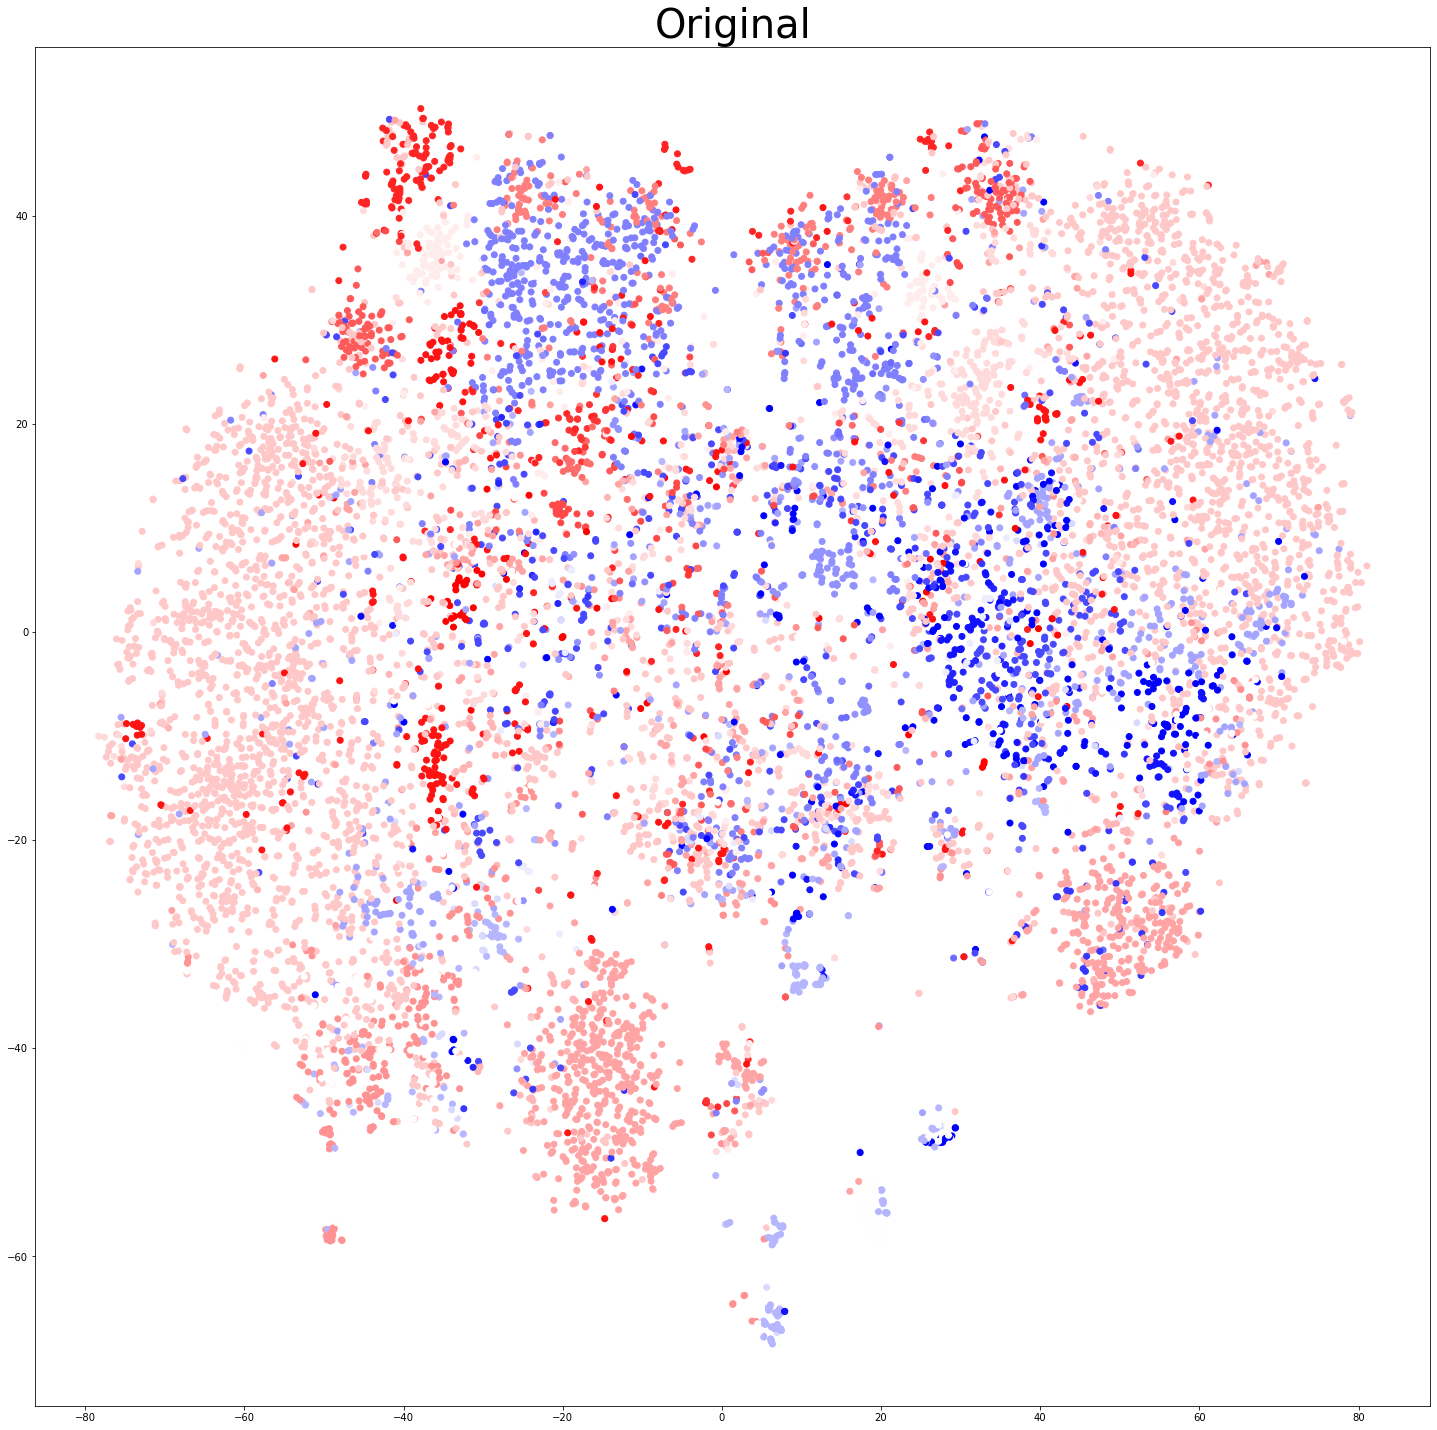

In [77]:
color_order = np.zeros(len(x_dev), )

for i in range(28):
    indices = np.where(y_dev == projection_order_from_min[i])
    if i < 11:
        color_order[indices] = i - 11
    else:
        color_order[indices] = i - 10
        
tsne_by_gender(x_dev[color_order != -6], color_order[color_order != -6], "Original")

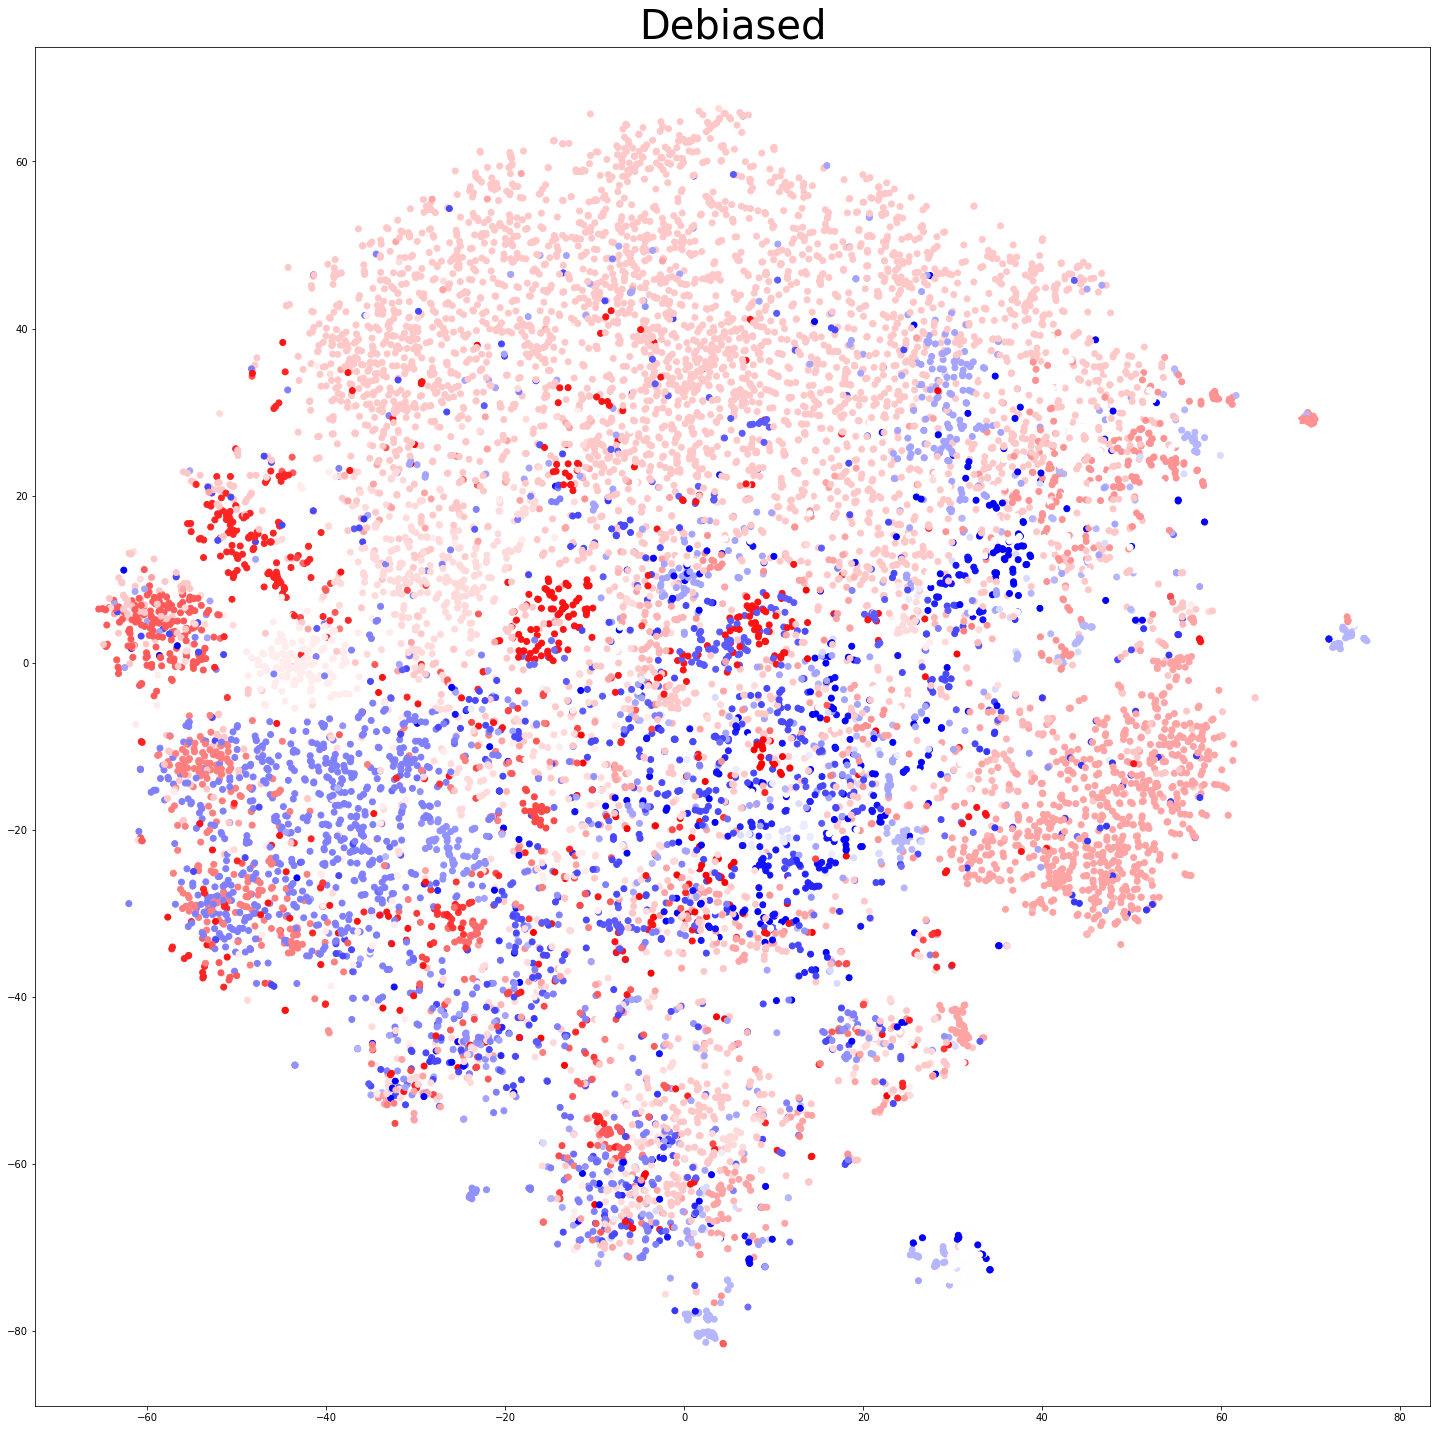

In [74]:
color_order = np.zeros(len(x_dev), )

for i in range(28):
    indices = np.where(y_dev == projection_order_from_min[i])
    if i < 11:
        color_order[indices] = i - 11
    else:
        color_order[indices] = i - 10
    
def tsne_by_gender(vecs, labels, title, words = None):

    tsne = TSNE(n_components=2, random_state=0)
    vecs_2d = tsne.fit_transform(vecs)
    plt.figure(figsize=(25, 25))

    plt.scatter(vecs_2d[: , 0], vecs_2d[: , 1], c = labels, cmap = 'bwr')
    plt.title(title, fontsize = 40)
    plt.show()
    return

tsne_by_gender(debiased_x_dev, color_order, "Debiased")

Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


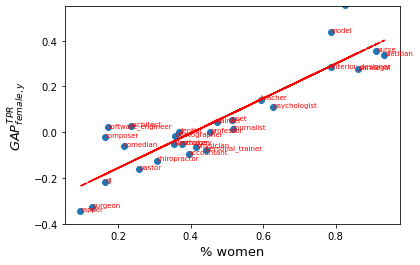

In [81]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)

In [85]:
tprs_change_before

{'filmmaker': -0.05114394827566193,
 'journalist': 0.012408778080768679,
 'professor': -0.0002867038068653516,
 'photographer': -0.016113676109134834,
 'dentist': -0.0007096935793603487,
 'nurse': 0.35323565323565326,
 'attorney': -0.05312552833337003,
 'painter': 0.044230654419227355,
 'accountant': -0.09645945746174889,
 'poet': 0.05410263640208657,
 'physician': -0.0654741573033708,
 'dietitian': 0.3361344537815126,
 'surgeon': -0.32725783329920133,
 'interior_designer': 0.2853363567649282,
 'chiropractor': -0.12383900928792574,
 'teacher': 0.14292333515951922,
 'architect': 0.028619528619528656,
 'psychologist': 0.11027310924369749,
 'model': 0.4371184371184371,
 'yoga_teacher': 0.5575684380032206,
 'pastor': -0.16253119953017175,
 'software_engineer': 0.02325138174194774,
 'comedian': -0.06102671555788375,
 'paralegal': 0.2777777777777778,
 'rapper': -0.3426966292134831,
 'composer': -0.022812667740204073,
 'dj': -0.2179878048780488,
 'personal_trainer': -0.07553191489361699}

In [82]:
projection_order_from_min = (-np.fromiter(tprs_change_before.values(), dtype=float)).argsort()
professions_list_by_gender = [list(tprs_change_before.keys())[i] for i in projection_order_from_min]
professions_int_by_gender = [p2i[i] for i in professions_list_by_gender]
color_order = np.zeros(len(x_dev), )
        
for i in range(28):
    indices = np.where(y_dev == professions_int_by_gender[i])
    if i < 13:
        color_order[indices] = i - 13
    else:
        color_order[indices] = i - 12

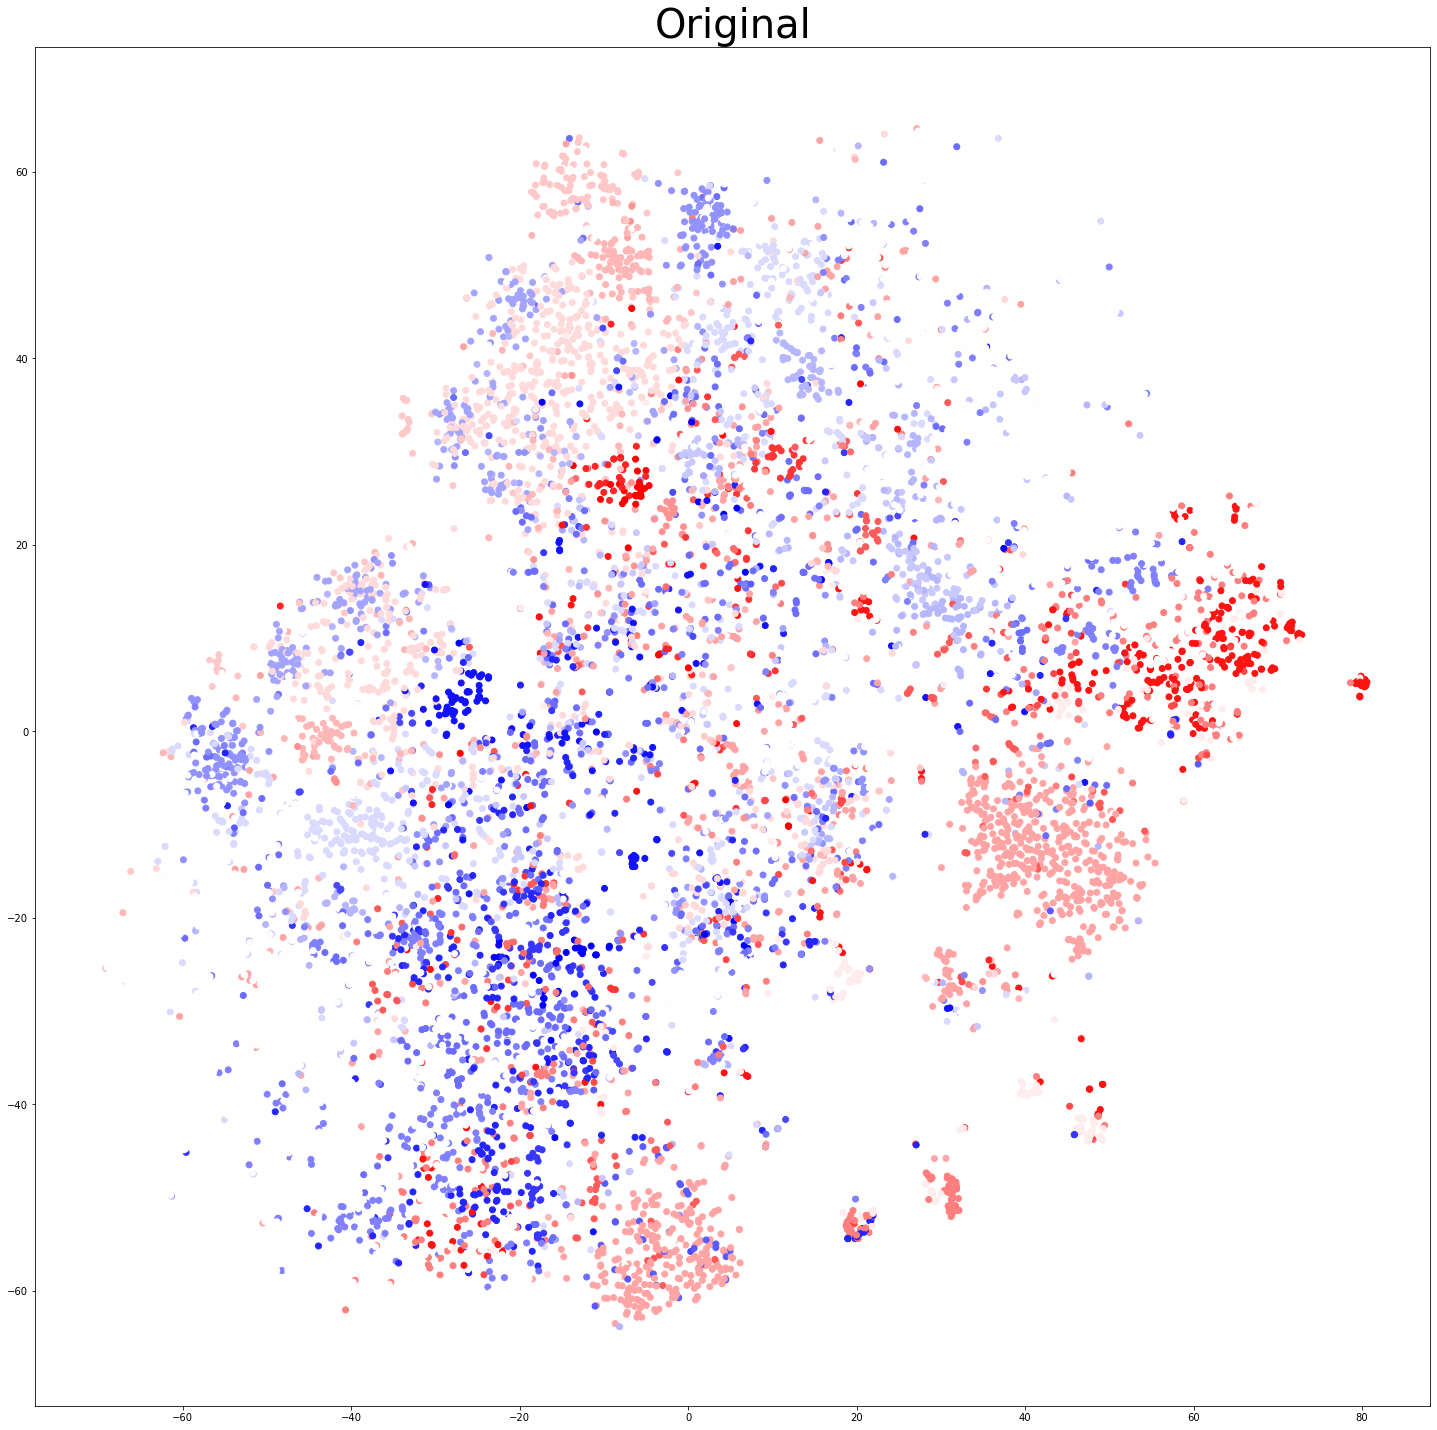

In [84]:
tsne_by_gender(x_dev, color_order, "Original")

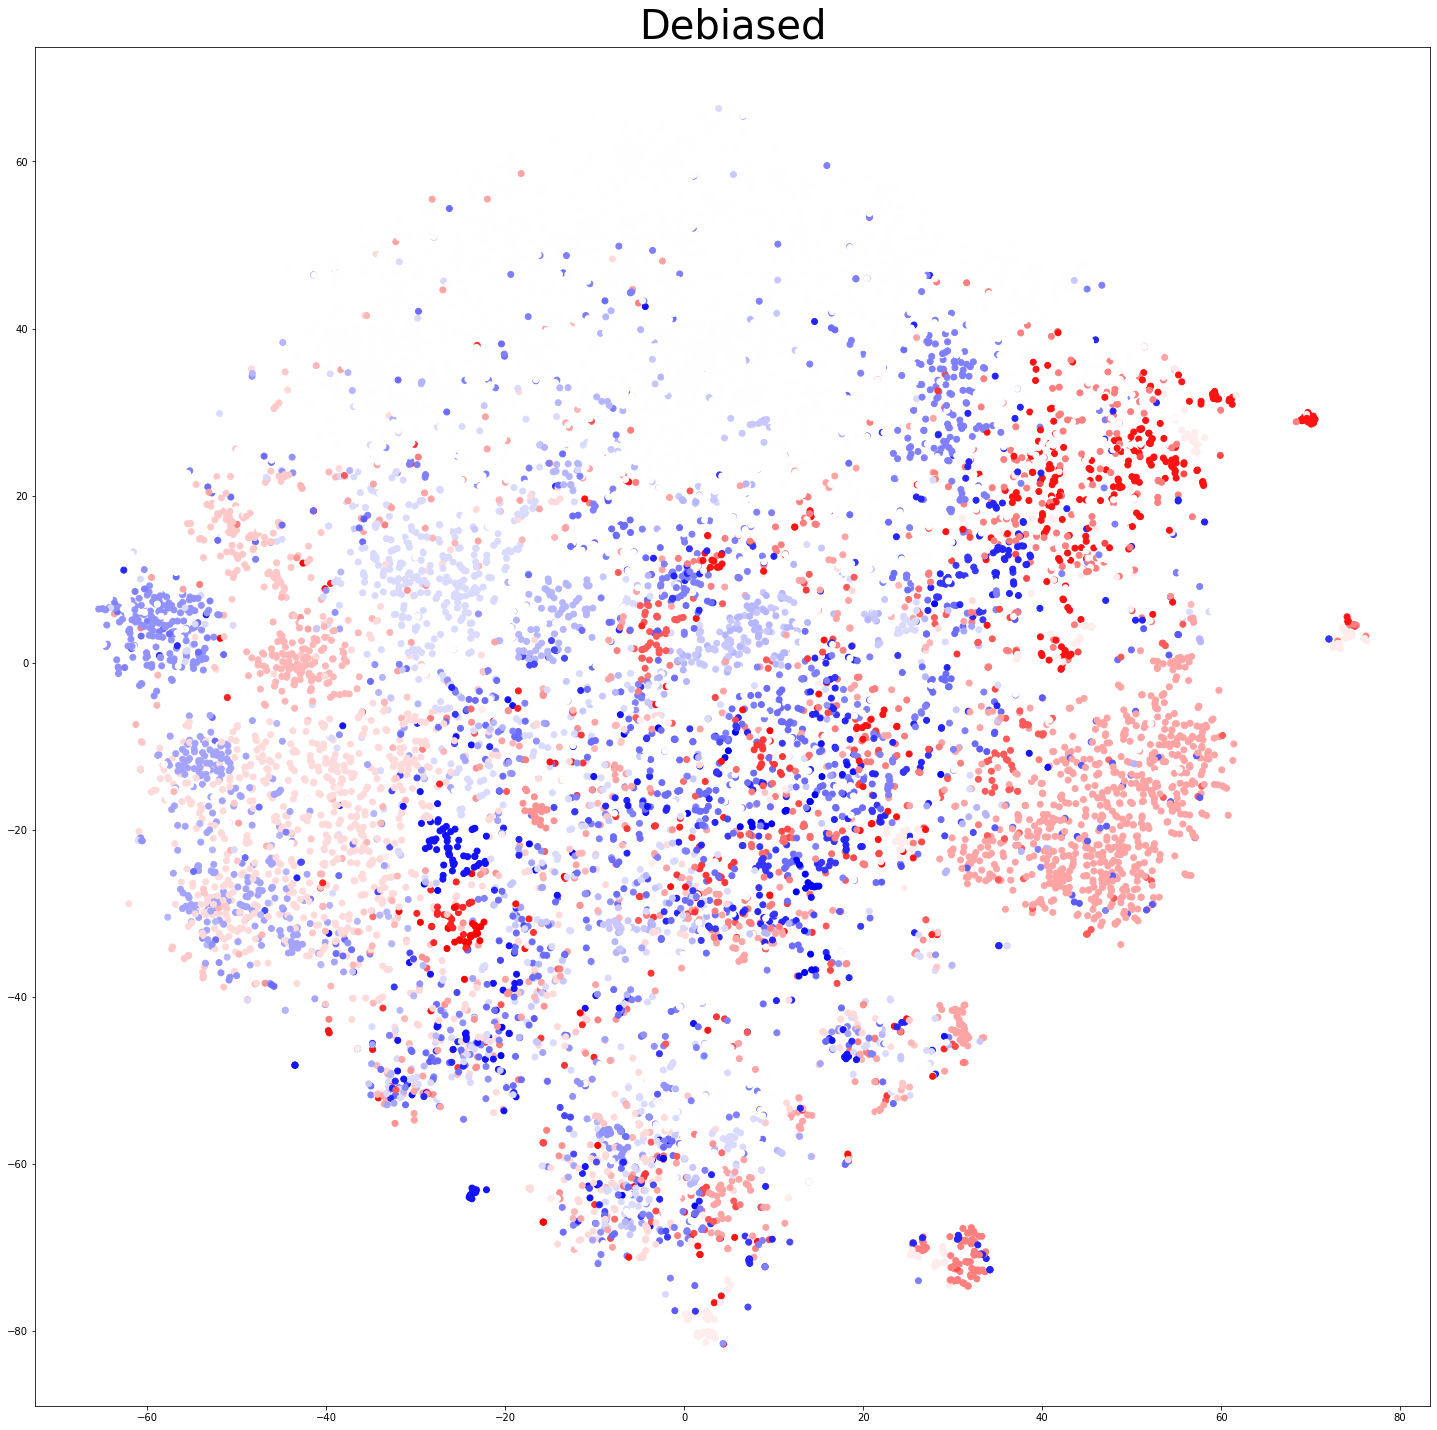

In [83]:
tsne_by_gender(debiased_x_dev, color_order, "Debiased")

In [198]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

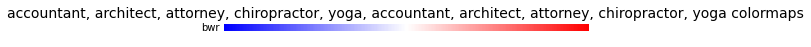

In [201]:
plot_color_gradients('accountant, architect, attorney, chiropractor, yoga, accountant, architect, attorney, chiropractor, yoga', ['bwr'])

In [ ]:
tsne_by_gender(debiased_x_dev[:5000], y_dev_gender[:5000], "Projected")

In [149]:
i2p[1]

'architect'

In [144]:
np.random.rand(x_test.shape[0])

array([0.83100977, 0.88313555, 0.35724062, ..., 0.09520834, 0.2411776 ,
       0.25320473])

In [ ]:
y_test_gender = np.array([d["g"] for d in dev])
n = 2000
for prof in ["nurse", "professor", "physician", "accountant", "dj", "dietitian"]:
    
    idx = np.random.rand(x_test.shape[0]) < 0.1
    prof_idx = y_dev == p2i[prof]  
    prof_upper = prof[0].upper() + prof[1:]
    tsne_by_gender(x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Original)".format(prof_upper))
    tsne_by_gender(debiased_x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Projected)".format(prof_upper))



In [146]:
y_dev_gender == 1

array([ True,  True, False, ..., False,  True, False])

No handles with labels found to put in legend.


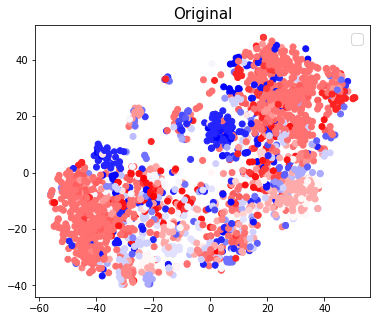

array([[-52.50161  , -19.610743 ],
       [-28.97927  , -20.522741 ],
       [-12.222881 ,  21.018864 ],
       ...,
       [ 28.740929 , -12.31069  ],
       [-37.18483  ,   7.8229685],
       [-18.541538 ,  -3.7423368]], dtype=float32)

In [ ]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = list(set(labels)) # ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'b', 'r', 'orange'
  markers = ["o", "s"]

  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(f"i is {i}, colour is {c}, label is {label}, marker is {marker}")
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label="Female" if label == 1 else "Male", alpha = 0.45)
  plt.legend(fontsize = 15, loc = "upper right")
  plt.title(title, fontsize = 15)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig(title, dpi = 600)          
  plt.show()
  return vecs_2d

25
260


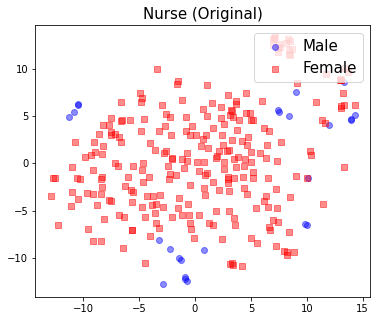

25
260


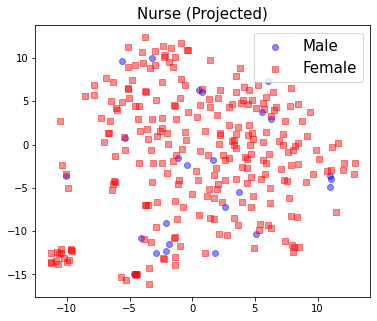

1077
923


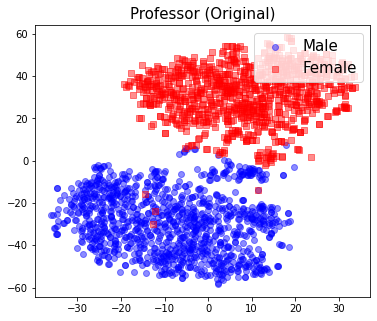

1077
923


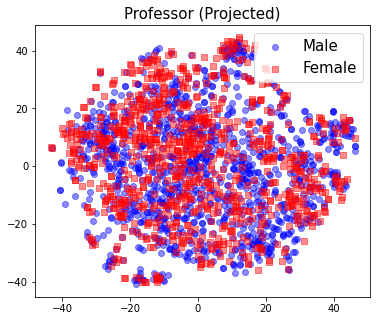

250
178


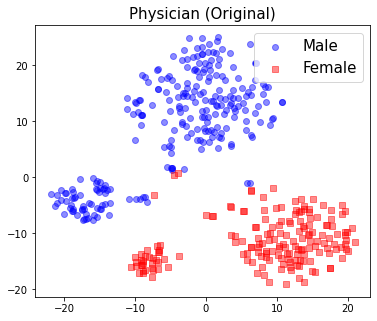

250
178


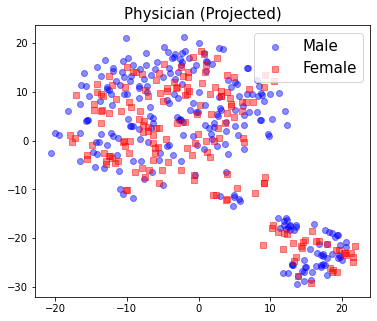

100
65


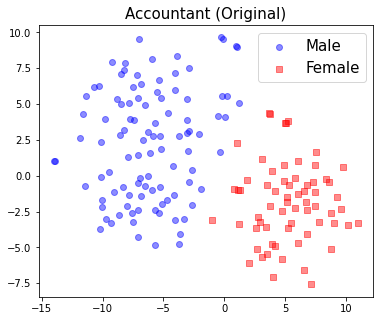

100
65


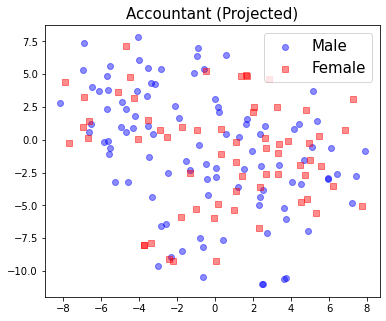

33
7


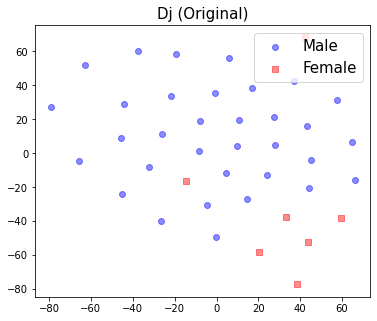

33
7


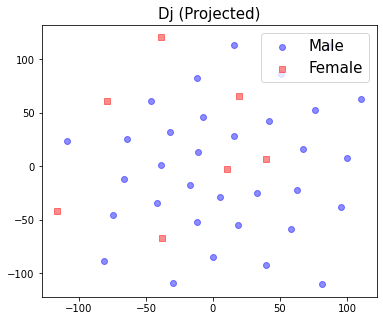

8
116


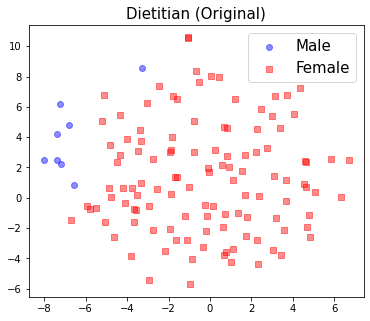

8
116


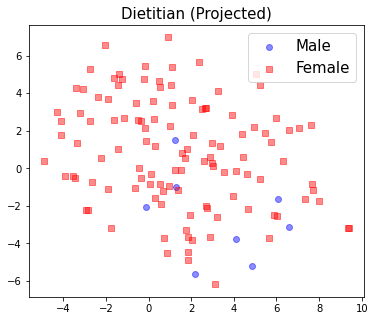

In [17]:
y_test_gender = np.array([d["g"] for d in dev])
n = 2000
for prof in ["nurse", "professor", "physician", "accountant", "dj", "dietitian"]:
    
    idx = np.random.rand(x_test.shape[0]) < 0.1
    prof_idx = y_dev == p2i[prof]  
    prof_upper = prof[0].upper() + prof[1:]
    tsne_by_gender(x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Original)".format(prof_upper))
    tsne_by_gender(debiased_x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Projected)".format(prof_upper))

In [ ]:
y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_train_gender = np.array([g2i[d["g"]] for d in train])
y_test_gender = np.array([g2i[d["g"]] for d in test])

In [21]:
set(y_dev[:n].tolist())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27}

1096
904


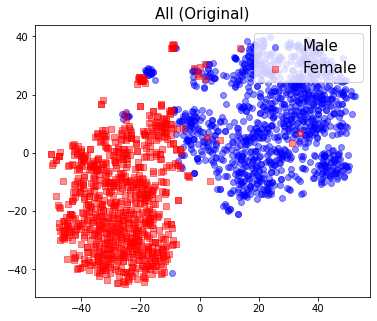

1096
904


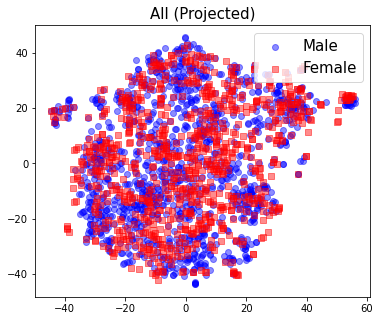

array([[-22.383366 , -30.305668 ],
       [ -8.941171 ,   2.5040379],
       [-43.64478  ,  19.522036 ],
       ...,
       [  0.6562191,  41.36733  ],
       [ 19.82849  , -14.077178 ],
       [ 12.478728 ,   4.5857434]], dtype=float32)

In [18]:
tsne_by_gender(x_dev[:n], y_dev_gender[:n], "All (Original)".format(prof_upper))
tsne_by_gender(debiased_x_dev[:n], y_dev_gender[:n], "All (Projected)".format(prof_upper))

In [20]:
set(y_dev_gender[:n].tolist())

{0, 1}

In [ ]:
def visualize_gender_subspace(proj_matrices, vecs):
    
        labels = range(len(proj_matrices))
        N = len(labels)
        
        all_vecs = []
        all_labels = []
        
        for i,p in enumerate(proj_matrices):
            
            vecs_proj = vecs - vecs.dot(p)
            all_vecs.append(vecs_proj)
            all_labels.append(np.ones(vecs.shape[0]) * i)
        
        all_vecs_np = np.concatenate(all_vecs, axis = 0)
        all_labels_np = np.concatenate(all_labels, axis = 0)
        tsne = TSNE(n_components=2, random_state=0)
        vecs_2d = tsne.fit_transform(all_vecs_np)
    
        fig, ax = plt.subplots()
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        print("here")
        print(all_labels_np.shape)
        scat = ax.scatter(vecs_2d[:,0], vecs_2d[:,1], c=all_labels_np, cmap=cmap, norm=norm, alpha=0.4)
        cb = plt.colorbar(scat, spacing='proportional')#, ticks=bounds)
        cb.set_label("INLP iteration number")
        plt.savefig("INLP progress", dpi = 600)
        plt.show()

In [ ]:
visualize_gender_subspace(all_Ps[:25], x_dev[:5000])